# Normal Day Analysis

In [1]:
import pandas as pd
import numpy as np
import ipaddress
import dns.resolver
import dns.reversename
import pygeoip
import matplotlib.pyplot as plt 
# Step 5: Adjust the pandas display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 240)
pd.set_option('display.colheader_justify', 'left')
pd.set_option('display.expand_frame_repr', False)


In [38]:
from collections import Counter
def count_letters(letter_list):
    return dict(Counter(letter_list))
def get_top_3_counts(letter_count,n=3):
    # Sort the counts in descending order and get the top 3
    return dict(Counter(letter_count).most_common(n))
def ts_to_hour(timestamp):
        # Convert 1/100th of seconds to total seconds
    total_seconds = timestamp / 100
    
    # Calculate hours, minutes, and seconds
    hours = int(total_seconds // 3600)
    remaining_seconds_after_hours = total_seconds % 3600
    minutes = int(remaining_seconds_after_hours // 60)
    seconds = remaining_seconds_after_hours % 60
    
    # Format seconds to include fractional part
    hms = f"{hours:02}"
    return hms

'00'

In [4]:
datafile='data7.parquet'

In [5]:
gi=pygeoip.GeoIP('./GeoIP.dat')
gi2=pygeoip.GeoIP('./GeoIPASNum.dat')
addr='193.136.73.21'
cc=gi.country_code_by_addr(addr)
org=gi2.org_by_addr(addr)
print(cc,org)

PT AS1930 Fundacao para a Ciencia e a Tecnologia, I.P.


In [6]:
data=pd.read_parquet(datafile)

In [7]:
data.head()

,timestamp,src_ip,dst_ip,proto,port,up_bytes,down_bytes
index,,,,,,,
709945,1232147,192.168.107.196,192.168.107.234,udp,53,157,224
709946,1232151,192.168.107.196,192.168.107.234,udp,53,157,227
709947,1232156,192.168.107.196,192.168.107.234,udp,53,154,219
709948,1232265,192.168.107.196,157.240.212.35,tcp,443,13896,113280
709949,1232398,192.168.107.196,157.240.212.35,tcp,443,45276,419472


In [8]:
NET=ipaddress.IPv4Network('192.168.107.0/24')
private_dst_normal = data[data.apply(lambda x: ipaddress.IPv4Address(x['dst_ip']) in NET,axis=1)]

private_dst_normal.head()


,timestamp,src_ip,dst_ip,proto,port,up_bytes,down_bytes
index,,,,,,,
709945,1232147,192.168.107.196,192.168.107.234,udp,53,157,224
709946,1232151,192.168.107.196,192.168.107.234,udp,53,157,227
709947,1232156,192.168.107.196,192.168.107.234,udp,53,154,219
709954,1232769,192.168.107.196,192.168.107.226,tcp,443,13661,134605
709967,1234167,192.168.107.196,192.168.107.226,tcp,443,5129,39416


In [9]:
private_dst_normal.groupby("src_ip")["dst_ip"].agg(set)

src_ip
192.168.107.100    {192.168.107.234, 192.168.107.227, 192.168.107...
192.168.107.101    {192.168.107.234, 192.168.107.227, 192.168.107...
192.168.107.102    {192.168.107.234, 192.168.107.227, 192.168.107...
192.168.107.103    {192.168.107.234, 192.168.107.227, 192.168.107...
192.168.107.104    {192.168.107.234, 192.168.107.227, 192.168.107...
                                         ...                        
192.168.107.95     {192.168.107.234, 192.168.107.227, 192.168.107...
192.168.107.96     {192.168.107.234, 192.168.107.227, 192.168.107...
192.168.107.97     {192.168.107.234, 192.168.107.227, 192.168.107...
192.168.107.98     {192.168.107.234, 192.168.107.227, 192.168.107...
192.168.107.99     {192.168.107.234, 192.168.107.227, 192.168.107...
Name: dst_ip, Length: 199, dtype: object

### Comunicacoes com ip's internos
"{'192.168.107.226', '192.168.107.223', '192.168.107.234', '192.168.107.227', '192.168.107.222', '192.168.107.238'}"

In [10]:
grp_private_normal = private_dst_normal.groupby(["proto","port"])['dst_ip'].apply(list)

In [11]:
data.groupby("src_ip")["dst_ip"].count().reset_index().sort_values(by="dst_ip", ascending=False)

,src_ip,dst_ip
44,192.168.107.140,12666
42,192.168.107.139,11758
150,192.168.107.51,11739
145,192.168.107.46,10673
169,192.168.107.70,10622
...,...,...
8,192.168.107.108,892
180,192.168.107.81,597
196,192.168.107.97,570
121,192.168.107.22,499


In [12]:
data_ratios = data.copy()

In [13]:
data_ratios.loc[:,"ratio"] = data_ratios["up_bytes"] / data_ratios["down_bytes"]

In [14]:
data.groupby("src_ip")["down_bytes"].min().mean()

187.3819095477387

## Max Up bytes and down bytes on average
66764 up bytes

3959601 down bytes

## Min Up bytes and down bytes on average

114 up bytes

187 down bytes

## Min Ratio on average

0.155 ratio (up/down)

## Max Ratio on average

0.174 ratio (up/down)


In [15]:
data.groupby("src_ip").agg({
"up_bytes" : ["min","max","mean"],"down_bytes": ["min","max","mean"]
}).reset_index()


src_ip           up_bytes                      down_bytes                       
                     min      max    mean          min        max      mean         
0    192.168.107.100  134      64916  10116.875462  200        2194635  92705.122894
1    192.168.107.101  110      72872  10025.303948  176        3898754  94732.699947
2    192.168.107.102  129      78041   9678.595481  221        2814076  90240.021866
3    192.168.107.103  105      92018   9972.337606  168        4794581  94036.708612
4    192.168.107.104  108      67244   9873.292324  159        3862085  93812.450054
..               ...      ...    ...           ...        ...      ...           ...
194   192.168.107.95  107      68304  10043.766040  151        4577195  94093.268957
195   192.168.107.96  121      67178   9938.511026  196        2871762  88812.157534
196   192.168.107.97  125      35646   9966.408772  277         371164  84183.878947
197   192.168.107.98  113      59741  10031.142893  175        3468603  94293.416155
198   192.168.107.99  139      48841  10080.663830  247        2885880  97887.336170

[199 rows x 7 columns]

### Horas de trabalho

In [32]:
maxt = data.copy()
maxt["timestamp"] = maxt["timestamp"].apply(ts_to_hour)


In [33]:
grouped_df = maxt.groupby(['timestamp']).agg({
    'timestamp': 'count',  # Count occurrences of each timestamp
    'up_bytes': 'sum',       # Sum upbytes for each group
    'down_bytes': 'sum'       # Sum upbytes for each group
}).rename(columns={'timestamp': 'timestamp_count'})

In [34]:
grouped_df=grouped_df.reset_index()

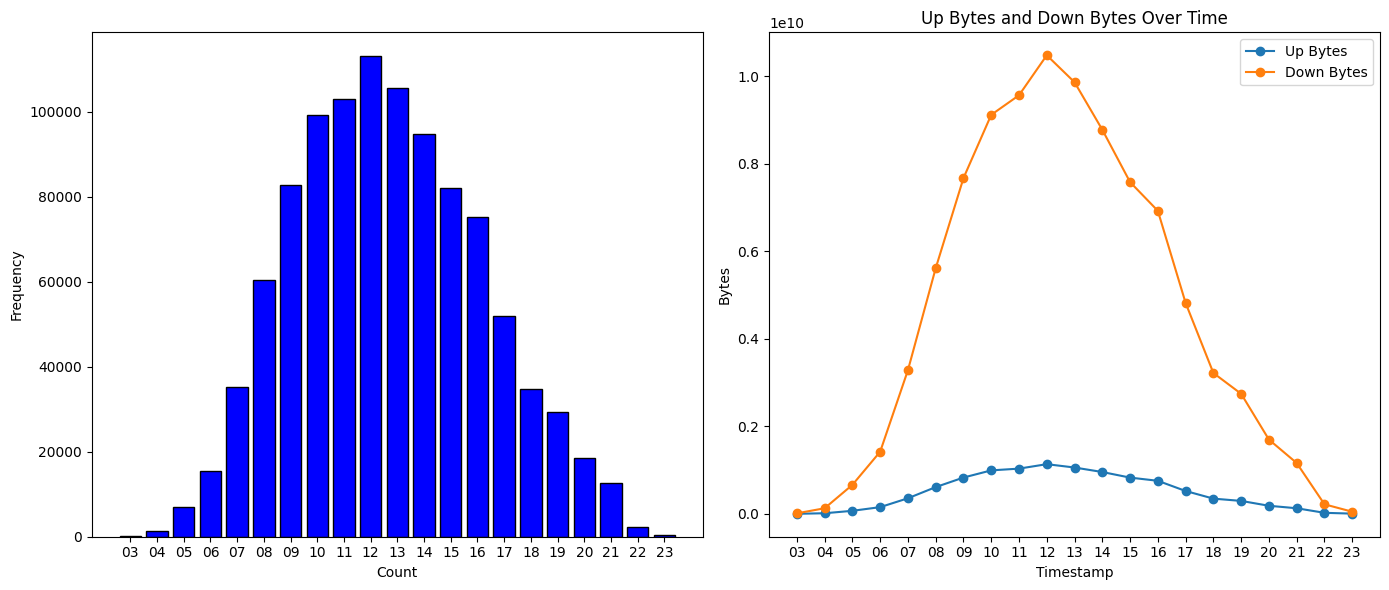

In [35]:

# Plotting
plt.figure(figsize=(14, 6))

# Histogram for timestamp count
plt.subplot(1, 2, 1)
plt.bar(grouped_df['timestamp'], grouped_df['timestamp_count'], color='blue', edgecolor='black')
plt.xlabel('Count')
plt.ylabel('Frequency')

# Line plot for up_bytes and down_bytes
plt.subplot(1, 2, 2)
plt.plot(grouped_df['timestamp'], grouped_df['up_bytes'], marker='o', label='Up Bytes')
plt.plot(grouped_df['timestamp'], grouped_df['down_bytes'], marker='o', label='Down Bytes')
plt.title('Up Bytes and Down Bytes Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Bytes')
plt.legend()

plt.tight_layout()
plt.show()

In [20]:
maxt.groupby("src_ip")["timestamp"].head()

index
709945    03
709946    03
709947    03
709954    03
709967    03
          ..
932539    13
932540    13
932541    13
932542    13
932543    13
Name: timestamp, Length: 995, dtype: object

In [21]:

times_cnt = maxt.groupby("src_ip")["timestamp"].value_counts().unstack(fill_value=0).reset_index()

In [22]:
times_cnt

timestamp,src_ip,03,04,05,06,07,08,09,10,11,12,13,14,15,16,17,18,19,20,21,22,23
0,192.168.107.100,0,0,0,0,0,0,0,0,62,140,192,239,25,0,0,0,0,0,0,0,0
1,192.168.107.101,0,0,0,0,0,18,255,64,75,274,286,314,217,278,7,0,0,0,0,0,0
2,192.168.107.102,0,0,0,0,0,258,0,0,197,7,0,0,0,0,0,0,0,0,0,0,0
3,192.168.107.103,0,0,0,0,0,0,0,109,0,47,352,177,208,222,152,78,225,0,0,0,0
4,192.168.107.104,0,0,23,147,263,208,0,0,152,181,236,287,305,297,195,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
194,192.168.107.95,0,0,0,0,0,42,277,229,1,44,209,276,242,310,299,0,0,0,0,0,0
195,192.168.107.96,0,0,0,0,28,27,43,298,83,196,239,18,95,271,60,140,326,0,0,0,0
196,192.168.107.97,0,0,0,0,0,0,0,0,169,0,0,0,0,0,0,0,0,0,0,0,0
197,192.168.107.98,0,0,0,0,0,154,257,260,266,268,240,217,212,176,256,19,0,0,0,0,0


In [23]:
column_sums = times_cnt[[f"{hours:02}" for hours in range(3,24)]].sum(axis=0)
column_sums['category'] = 'Total'

In [24]:
df = pd.DataFrame(column_sums)

In [25]:
print(df)

          0     
timestamp       
03            39
04           410
05          2116
06          4648
07         10249
08         17659
09         24360
10         29417
11         31029
12         33822
13         31061
14         27923
15         23411
16         22662
17         15487
18         10285
19          8585
20          5598
21          3536
22           673
23           172
category   Total


### Horas de trabalho mais comuns
| Hora de inicio | hora de fim ({Hora: Contagem}) |
|:----:|:------:|
| 03 |    {'17': 1} |
| 04 |    {'14': 2} |
| 05 |    {'17': 3} |
| 06 |    {'17': 4} |
| 07 |    {'17': 6} |
| 08 |    {'14': 5} |
| 09 |    {'17': 8} |
| 10 |    {'17': 7} |
| 11 |    {'16': 4} |
| 12 |    {'17': 3} |
| 13 |    {'17': 1} |

Hora mais comum e das 9 as 17.

Mas o intervalo mais abrangente e das 7 as 17.

In [26]:

https_servers = set(grp_private_normal[('tcp', 443)])
print()

dns_servers =  set(grp_private_normal[('udp', 53)])
print()

## Servers 
tcp 443 {'192.168.107.223', '192.168.107.238', '192.168.107.222', '192.168.107.226'} https

udp 53 {'192.168.107.227', '192.168.107.234'} dns


In [27]:
grouped = data.groupby(['src_ip','dst_ip']).sum()

# Calculate the ratio
grouped['ratio'] = grouped['up_bytes'] / grouped['down_bytes']
grouped
# Reset the index to make dst_ip a column again
# grouped = grouped.reset_index()

timestamp proto                                               port   up_bytes  down_bytes  ratio   
src_ip          dst_ip                                                                                                             
192.168.107.100 104.16.249.130   94725010  tcptcptcptcptcptcptcptcptcptcptcptcptcptcptcpt...   7974  209457    1727986     0.121215
                104.22.48.100    36323031                        tcptcptcptcptcptcptcptcptcp   3987   93381     814578     0.114637
                104.244.42.129  246717524  tcptcptcptcptcptcptcptcptcptcptcptcptcptcptcpt...  21707  512007    4246664     0.120567
                104.26.13.207   100077577  tcptcptcptcptcptcptcptcptcptcptcptcptcptcptcpt...   8860  270821    6675043     0.040572
                104.26.14.51     79996025   tcptcptcptcptcptcptcptcptcptcptcptcptcptcptcptcp   7088  205239    1890983     0.108536
...                                   ...                                                ...    ...       ...         ...       ...
192.168.107.99  66.22.229.4      11237553                                          tcptcptcp   1329   23809     267000     0.089172
                66.254.114.41    10868618                                          tcptcptcp   1329   37602     337169     0.111523
                88.157.217.145   66107954  tcptcptcptcptcptcptcptcptcptcptcptcptcptcptcpt...   7974  159654    1506733     0.105960
                88.157.217.146  120743878  tcptcptcptcptcptcptcptcptcptcptcptcptcptcptcpt...  14619  379690    4234007     0.089676
                97.107.142.234   30141613                           tcptcptcptcptcptcptcptcp   3544   71568     677703     0.105604

[27120 rows x 6 columns]

In [28]:
mean_ratios = grouped.groupby('src_ip')['ratio'].mean().reset_index()

In [29]:
server_traffic = data[data.apply(lambda x: x['dst_ip'] in dns_servers or x['dst_ip'] in https_servers,axis=1)]



In [30]:
server_traffic.head()

,timestamp,src_ip,dst_ip,proto,port,up_bytes,down_bytes
index,,,,,,,
709945,1232147,192.168.107.196,192.168.107.234,udp,53,157,224
709946,1232151,192.168.107.196,192.168.107.234,udp,53,157,227
709947,1232156,192.168.107.196,192.168.107.234,udp,53,154,219
709954,1232769,192.168.107.196,192.168.107.226,tcp,443,13661,134605
709967,1234167,192.168.107.196,192.168.107.226,tcp,443,5129,39416


In [31]:
server_traffic_http.size / server_traffic.size

NameError: name 'server_traffic_http' is not defined

#### src_ip connections to servers both dns or tcp

In [ ]:
server_traffic_dns = data[data.apply(lambda x: x['dst_ip'] in dns_servers,axis=1)]

server_traffic_http =  data[data.apply(lambda x: x['dst_ip'] in https_servers,axis=1)]

In [ ]:
server_traffic_dns.groupby("src_ip").sum().reset_index().drop(["dst_ip","proto","port","timestamp"],axis=1).groupby("src_ip").mean()

In [ ]:
server_traffic_http.groupby("src_ip").sum().reset_index().drop(["dst_ip","proto","port","timestamp"],axis=1).groupby("src_ip").mean()

In [ ]:
servers_grouped = server_traffic.groupby(['dst_ip','src_ip']).sum()

# Calculate the ratio
servers_grouped['ratio'] = servers_grouped['up_bytes'] / servers_grouped['down_bytes']
servers_grouped
# Reset the index to make dst_ip a column again
# grouped = grouped.reset_index()
servers_mean_ratios = servers_grouped.groupby('dst_ip')['ratio'].mean().reset_index()

In [ ]:
servers_mean_ratios.sort_values(by="ratio",ascending=False)

In [ ]:
servers_mean_ratios.to_csv("dst_ip_normal.csv")

In [ ]:
NET=ipaddress.IPv4Network('192.168.107.0/24')
private_dst_internal_normal = data[data.apply(lambda x: ipaddress.IPv4Address(x['dst_ip']) in NET  and  ipaddress.IPv4Address(x['src_ip']) in NET  ,axis=1)]

private_dst_internal_normal.head()

In [ ]:
private_dst_internal_normal.groupby("src_ip")['dst_ip'].agg(set).reset_index().to_csv("normal_coms_internal.csv")

print(private_dst_internal_normal.groupby("src_ip")['dst_ip'].agg(list).reset_index()[:]['src_ip'][0])
print(set(private_dst_internal_normal.groupby("src_ip")['dst_ip'].agg(list).reset_index()[:]['dst_ip'][0]))

In [ ]:
exterior = data[data.apply(lambda x: ipaddress.IPv4Address(x['dst_ip']) not in NET,axis=1)]
exterior.loc[:,'ratio'] = exterior['up_bytes']/exterior['down_bytes']

In [ ]:
grp_exterior_normal = exterior.groupby(["proto","port"])['dst_ip'].apply(list)

https_servers = set(grp_exterior_normal[('tcp', 443)])
print(https_servers)

ips_cc = {addr : gi.country_code_by_addr(addr) for addr in https_servers}
ips_cc_filtered = {k:v for k,v in ips_cc.items() if k not in ['US','GB','UK']}

# dns_servers =  set(grp_exterior_normal[('udp', 53)])
# print(dns_servers)

In [ ]:
exterior.groupby(['src_ip','dst_ip'])["ratio"].mean().reset_index().sort_values(ascending=False, by='ratio').to_csv("dst_ip_ratio_normal.csv")

In [ ]:
print("Numero de paises contactados", len(set(ips_cc.values())))